### Step 1: Reading and Understanding the Data

In [1]:
# Importing all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sqlite3
conn = sqlite3.connect('research.db')


###  Fetch all accounts

In [2]:
cur = conn.cursor()
cur.execute("select \"Id\", \"RecordType.Name\",\"Industry\",\"Business_Type__c\",\"Country__c\",\"Is_External__c\",\"ParentId\"from \"Account\" union \
select \"Id\", \"RecordType.Name\",\"Education\" as \"Industry\",\"Not for profit\" as \"Business_Type__c\",\"Australia\" as \"Country__c\", \
\"Is_External__c\",\"ParentId\" from \"Account_internal\"")
accounts_all = cur.fetchall()
accounts_all= pd.DataFrame(accounts_all)
accounts_all.columns= ['AccountID', 'AccountType','Industry','BusinessType','Country','Internal_External','ParentAccount']
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'Industry'] = 'Education'  
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'BusinessType'] = 'University'  
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'Country'] = 'Australia' 
accounts_all['f_Australia']=accounts_all['Country'].apply(lambda x: 1 if x == 'Australia' else 0)
accounts_all["f_parent"]=accounts_all['ParentAccount'].notnull().astype(int)
accounts_all=accounts_all.drop(["ParentAccount"],axis=1)
accounts_all=accounts_all.drop(["Country"],axis=1)

In [102]:
cur.execute("select * from \"Opportunities\"")
Opportunity_raw = cur.fetchall()
Opportunity_raw= pd.DataFrame(Opportunity_raw)
Opportunity_raw.columns= ['ID', 'outcome','status_reason','init_OppType','Opptype','Supppoted', 
                          'createDate','est_closeDate','act_closeDate', 'est_amt','est_proj','act_amt',
                          'act_proj','bd_cluster','bd_div','aud_type','course_type','accountId',
                          'cust_contact','lead_aca_contact','lead_faculty','lead_school','lead_dep','supp_1'
                          ,'supp_2','ownerid','parent_opp'
                         ]
Opportunity_raw.loc[Opportunity_raw["lead_faculty"].isnull(),"lead_faculty"] = "Missing Faculty"
Opportunity_raw.loc[Opportunity_raw["act_amt"].isnull(),"act_amt"] = Opportunity_raw["est_amt"] 
Opportunity_raw.loc[Opportunity_raw["act_amt"].isnull(),"act_amt"] = 0
Opportunity_raw.loc[Opportunity_raw["act_proj"].isnull(),"act_proj"] = Opportunity_raw["est_proj"]
Opportunity_raw.loc[Opportunity_raw["act_proj"].isnull(),"act_proj"] = 0
Opportunity_raw.loc[Opportunity_raw["act_closeDate"].isnull(),"act_closeDate"] = Opportunity_raw["est_closeDate"]
Opportunity_raw['createDate'] = Opportunity_raw['createDate'].str[:10]
Opportunity_raw['createDate'] = pd.to_datetime(Opportunity_raw['createDate'])
Opportunity_raw['act_closeDate'] = pd.to_datetime(Opportunity_raw['act_closeDate'])
Opportunity_raw['closeDate_month'] = Opportunity_raw['act_closeDate'].dt.month
Opportunity_raw['createDate_month'] = Opportunity_raw['createDate'].dt.month
Opportunity_raw['closeDate_year'] = Opportunity_raw['act_closeDate'].dt.year
Opportunity_raw['createDate_year'] = Opportunity_raw['createDate'].dt.year
Opportunity_raw['days_diff']=(Opportunity_raw['act_closeDate']-Opportunity_raw['createDate']).dt.days
Opportunity_raw["f_parent_opp"]=Opportunity_raw['parent_opp'].notnull().astype(int)
Opportunity_raw['RN'] = Opportunity_raw.sort_values(['createDate','act_closeDate'], ascending=[True,True]).groupby(['accountId']).cumcount() + 1
Opportunity_raw_after=Opportunity_raw[['outcome','Opptype','Supppoted', 
                          'days_diff','createDate','act_closeDate','closeDate_month','createDate_month','closeDate_year','createDate_year','act_amt',
                          'act_proj','accountId',
                          'lead_faculty','f_parent_opp','RN']]


In [103]:
Opportunity_raw_won=Opportunity_raw_after[Opportunity_raw_after.outcome=='Closed Won']
Opportunity_raw_won['RN_2'] = Opportunity_raw_won.sort_values(['createDate','act_closeDate'], ascending=[True,True]).groupby(['accountId']).cumcount() + 1
Opportunity_raw_won=Opportunity_raw_won[Opportunity_raw_won.RN==1]
Opportunity_raw_won=Opportunity_raw_won[['accountId','createDate']]
Opportunity_raw_won.columns=['accountID_match','firstwon_createdate']
Opportunity_raw_after=Opportunity_raw_after.merge(Opportunity_raw_won, left_on='accountId', right_on='accountID_match',how='left')
Opportunity_raw_after['f_won_before']=np.where((Opportunity_raw_after['createDate'] >= Opportunity_raw_after['firstwon_createdate']), 1, 0)


C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,outcome,Opptype,Supppoted,days_diff,createDate,act_closeDate,closeDate_month,createDate_month,closeDate_year,createDate_year,act_amt,act_proj,accountId,lead_faculty,f_parent_opp,RN,accountID_match,firstwon_createdate,f_won_before
0,Proposing,Custom Education (MSPACE Included),RIC-BD&I,423,2019-11-25,2021-01-21,1,11,2021,2019,594623,594623.0,0012e000003A6pIAAS,0012e000002Zmo0AAC,0,22,NaN,NaT,0
1,Closed Lost,Research Contract,RIC-BD&I,56,2018-12-17,2019-02-11,2,12,2019,2018,0,0,0012e000003A6qZAAS,Missing Faculty,0,112,NaN,NaT,0
2,Closed Lost,Research Contract,RIC RE&D and BD&I,77,2018-10-01,2018-12-17,12,10,2018,2018,0,0,0012e000003A6qZAAS,Missing Faculty,0,101,NaN,NaT,0
3,Closed Lost,Research Contract,RIC-BD&I,161,2018-12-17,2019-05-27,5,12,2019,2018,0,0,0012e000003A6qTAAS,Missing Faculty,0,17,0012e000003A6qTAAS,2016-06-10,1
4,Closed Lost,Research Contract,RIC RE&D and BD&I,77,2018-10-01,2018-12-17,12,10,2018,2018,0,0,0012e000003A6qZAAS,Missing Faculty,0,102,NaN,NaT,0
5,Closed Lost,Research Contract,RIC-BD&I,129,2019-01-18,2019-05-27,5,1,2019,2019,0,0,0012e000003A6qZAAS,Missing Faculty,0,115,NaN,NaT,0
6,Closed Lost,Research Contract,RIC RE&D and BD&I,53,2018-10-25,2018-12-17,12,10,2018,2018,0,0,0012e000003A6qZAAS,Missing Faculty,0,105,NaN,NaT,0
7,Closed Lost,Research Contract,RIC RE&D and BD&I,15,2018-12-02,2018-12-17,12,12,2018,2018,0,0,0012e000003A6qZAAS,Missing Faculty,0,108,NaN,NaT,0
8,Closed Lost,Custom Education (MSPACE Included),RIC RE&D and BD&I,8,2018-11-12,2018-11-20,11,11,2018,2018,0,0,0012e000003A6Q9AAK,Missing Faculty,0,3,NaN,NaT,0
9,Closed Lost,Research Contract,RIC RE&D and BD&I,108,2018-08-31,2018-12-17,12,8,2018,2018,0,0,0012e000003A6ugAAC,Missing Faculty,0,1,NaN,NaT,0


In [107]:
merged=Opportunity_raw_after.merge(accounts_all, left_on='accountId', right_on='AccountID',how='left')
merged=merged.drop(["accountId","AccountID","accountID_match","firstwon_createdate","createDate","act_closeDate"],axis=1)
merged_data=merged[(merged.outcome == 'Closed Lost')|(merged.outcome =='Closed Won')]

In [108]:
merged_data.to_csv('merged_data.csv',index=False)

In [109]:
print(len(merged_data))
merged_data=merged_data[~merged_data.AccountType.isna()]
merged_data=merged_data[~merged_data.BusinessType.isna()]
print(len(merged_data))
merged_data.to_csv('merged_data_final.csv',index=False)

X = merged_data.iloc[:, 1:].values
y = merged_data.iloc[:, 0].values


6335
5689


In [110]:
from sklearn.preprocessing import LabelEncoder

labelencoder_X = LabelEncoder()
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,1] = labelencoder_X.fit_transform(X[:,1])
X[:,9] = labelencoder_X.fit_transform(X[:,9])
X[:,13] = labelencoder_X.fit_transform(X[:,13])
X[:,14] = labelencoder_X.fit_transform(X[:,14])
X[:,15] = labelencoder_X.fit_transform(X[:,15])
X[:,16] = labelencoder_X.fit_transform(X[:,16])


labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (4551, 19) (4551,)
Test (1138, 19) (1138,)


In [112]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.64
Accuracy of Logistic regression classifier on test set: 0.66


In [113]:
scores = cross_val_score(estimator=logreg, X=X, y=y, cv=10, n_jobs=4)
print(scores)

[0.64850615 0.64674868 0.63796134 0.64674868 0.63796134 0.64674868
 0.64674868 0.64674868 0.64674868 0.64788732]


Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: -0.00002
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: -0.00015
Feature: 6, Score: -0.00015
Feature: 7, Score: -0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000
Feature: 16, Score: -0.00000
Feature: 17, Score: -0.00000
Feature: 18, Score: -0.00000


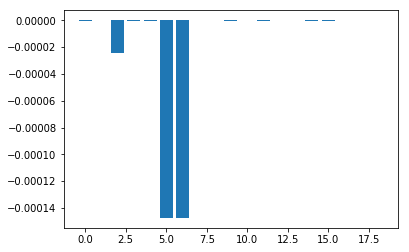

In [114]:
# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [115]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.90


In [116]:
scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, n_jobs=4)
print(scores)

[0.90509666 0.89279438 0.83304042 0.85588752 0.77328647 0.89455185
 0.89103691 0.92091388 0.91036907 0.86971831]


Feature: 0, Score: 0.01467
Feature: 1, Score: 0.01383
Feature: 2, Score: 0.07942
Feature: 3, Score: 0.01613
Feature: 4, Score: 0.01961
Feature: 5, Score: 0.05246
Feature: 6, Score: 0.00865
Feature: 7, Score: 0.02190
Feature: 8, Score: 0.42896
Feature: 9, Score: 0.03630
Feature: 10, Score: 0.00609
Feature: 11, Score: 0.14381
Feature: 12, Score: 0.11431
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01174
Feature: 15, Score: 0.02732
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00295
Feature: 18, Score: 0.00185


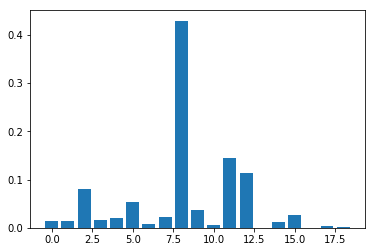

In [117]:
# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Accuracy of Random Forest  Classifier on training set: 1.00
Accuracy of Random Forest Classifier on test set: 1.00
Feature: 0, Score: 0.02625
Feature: 1, Score: 0.01852
Feature: 2, Score: 0.09409
Feature: 3, Score: 0.03161
Feature: 4, Score: 0.02657
Feature: 5, Score: 0.04464
Feature: 6, Score: 0.02293
Feature: 7, Score: 0.16828
Feature: 8, Score: 0.22837
Feature: 9, Score: 0.05118
Feature: 10, Score: 0.01160
Feature: 11, Score: 0.09501
Feature: 12, Score: 0.11688
Feature: 13, Score: 0.00043
Feature: 14, Score: 0.02189
Feature: 15, Score: 0.02911
Feature: 16, Score: 0.00042
Feature: 17, Score: 0.00568
Feature: 18, Score: 0.00652


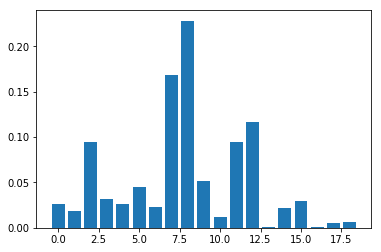

In [118]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
# fit the model
model.fit(X, y)

print('Accuracy of Random Forest  Classifier on training set: {:.2f}'
     .format(model.score(X_train, y_train)))
print('Accuracy of Random Forest Classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [119]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.87
Accuracy of K-NN classifier on test set: 0.84


In [120]:
scores = cross_val_score(estimator=knn, X=X, y=y, cv=10, n_jobs=4)
print(scores)


[0.86818981 0.82073814 0.72759227 0.81898067 0.78207381 0.8400703
 0.83831283 0.85588752 0.81370826 0.83098592]


In [121]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.78
Accuracy of LDA classifier on test set: 0.78


In [122]:
scores = cross_val_score(estimator=lda, X=X, y=y, cv=10, n_jobs=4)
print(scores)


[0.76098418 0.77680141 0.84182777 0.8400703  0.74165202 0.78558875
 0.71704745 0.79086116 0.74692443 0.75      ]


In [123]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.66
Accuracy of GNB classifier on test set: 0.67


In [124]:
scores = cross_val_score(estimator=gnb, X=X, y=y, cv=10, n_jobs=4)
print(scores)

[0.57469244 0.65202109 0.6115993  0.56942004 0.69771529 0.76801406
 0.44639719 0.51142355 0.49384886 0.53873239]


In [125]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.65
Accuracy of SVM classifier on test set: 0.64


In [126]:
scores = cross_val_score(estimator=svm, X=X, y=y, cv=10, n_jobs=4)
print(scores)


[0.66256591 0.6344464  0.5659051  0.64323374 0.66080844 0.61862917
 0.66256591 0.64850615 0.67135325 0.64964789]


[0.92794376 0.94376098 0.80140598 0.90685413 0.75571178 0.90333919
 0.91388401 0.9543058  0.93848858 0.88556338]
Feature: 0, Score: 0.02350
Feature: 1, Score: 0.01624
Feature: 2, Score: 0.03605
Feature: 3, Score: 0.01829
Feature: 4, Score: 0.00700
Feature: 5, Score: 0.13064
Feature: 6, Score: 0.00928
Feature: 7, Score: 0.01459
Feature: 8, Score: 0.35294
Feature: 9, Score: 0.02953
Feature: 10, Score: 0.03969
Feature: 11, Score: 0.10649
Feature: 12, Score: 0.17001
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01937
Feature: 15, Score: 0.01365
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.01273
Feature: 18, Score: 0.00000


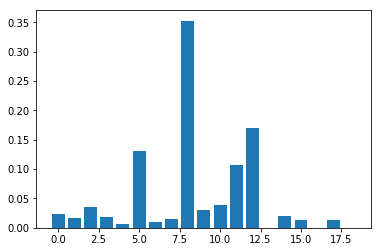

In [127]:
# xgboost for feature importance on a classification problem
from xgboost import XGBClassifier
from matplotlib import pyplot
# define dataset
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
scores = cross_val_score(estimator=model, X=X, y=y, cv=10, n_jobs=4)
print(scores)

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


[0.86818981 0.82073814 0.72759227 0.81898067 0.78207381 0.8400703
 0.83831283 0.85588752 0.81370826 0.83098592]
Feature: 0, Score: 0.00000
Feature: 1, Score: -0.00014
Feature: 2, Score: 0.04250
Feature: 3, Score: -0.00137
Feature: 4, Score: -0.00193
Feature: 5, Score: -0.00039
Feature: 6, Score: -0.00074
Feature: 7, Score: 0.15729
Feature: 8, Score: 0.28592
Feature: 9, Score: 0.00260
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00679
Feature: 12, Score: 0.00011
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.00035
Feature: 15, Score: 0.00014
Feature: 16, Score: 0.00000
Feature: 17, Score: -0.00018
Feature: 18, Score: 0.00000


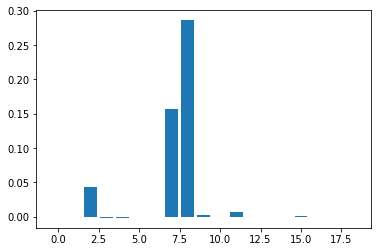

In [128]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset

# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X, y)

scores = cross_val_score(estimator=model, X=X, y=y, cv=10, n_jobs=4)
print(scores)

# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()